# Neural Network from Scratch

In this project, we'll implement a basic feedforward neural network using only NumPy to classify synthetic images of letters A, B, and C.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


## Define Binary Patterns for Letters A, B, and C

Each image is a 5x6 (30-pixel) grid encoded as a 1D array with binary values (0s and 1s).

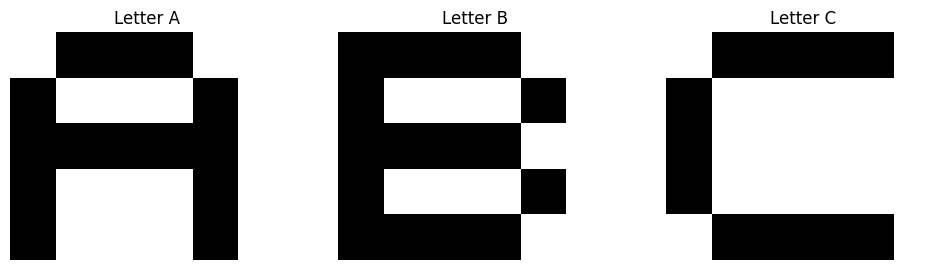

In [2]:
# Define binary patterns for letters A, B, and C as 5x6 grids
pattern_A = np.array([
    [0, 1, 1, 1, 0, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 1, 1, 1, 1, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 0]
])

pattern_B = np.array([
    [1, 1, 1, 1, 0, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 1, 1, 1, 0, 0],
    [1, 0, 0, 0, 1, 0],
    [1, 1, 1, 1, 0, 0]
])

pattern_C = np.array([
    [0, 1, 1, 1, 1, 0],
    [1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 0]
])

# Flatten the patterns to 1D arrays
pattern_A_flat = pattern_A.flatten()
pattern_B_flat = pattern_B.flatten()
pattern_C_flat = pattern_C.flatten()

# Display the patterns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(pattern_A, cmap='binary', interpolation='nearest')
axes[0].set_title('Letter A')
axes[0].axis('off')

axes[1].imshow(pattern_B, cmap='binary', interpolation='nearest')
axes[1].set_title('Letter B')
axes[1].axis('off')

axes[2].imshow(pattern_C, cmap='binary', interpolation='nearest')
axes[2].set_title('Letter C')
axes[2].axis('off')

plt.show()

## Prepare Training Data

Create training examples by adding some noise to the original patterns to make the problem more interesting.

In [3]:
def add_noise_to_pattern(pattern, noise_level=0.1):
    """Add random noise to a binary pattern"""
    noisy_pattern = pattern.copy().astype(float)
    noise_mask = np.random.random(noisy_pattern.shape) < noise_level
    # Flip bits where noise mask is True
    noisy_pattern[noise_mask] = 1 - noisy_pattern[noise_mask]
    return noisy_pattern

# Create training data
num_samples_per_class = 100
X = []  # Features
y = []  # Labels (0 for A, 1 for B, 2 for C)

for i in range(num_samples_per_class):
    # Add noisy versions of each pattern
    X.append(add_noise_to_pattern(pattern_A_flat, noise_level=0.1))
    y.append(0)  # Label for A
    
    X.append(add_noise_to_pattern(pattern_B_flat, noise_level=0.1))
    y.append(1)  # Label for B
    
    X.append(add_noise_to_pattern(pattern_C_flat, noise_level=0.1))
    y.append(2)  # Label for C

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# One-hot encode the labels
y_one_hot = np.eye(3)[y]

print(f"Training data shape: {X.shape}")
print(f"Labels shape: {y_one_hot.shape}")

Training data shape: (300, 30)
Labels shape: (300, 3)


## Neural Network Implementation

Now we'll implement our neural network from scratch with:
- Sigmoid activation function
- Forward propagation
- Backward propagation (backpropagation)
- Weight updates using gradient descent

In [4]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.1):
        """
        Initialize the neural network
        
        Args:
            input_size: Number of input features (30 for 5x6 images)
            hidden_size: Number of neurons in hidden layer
            output_size: Number of output classes (3 for A, B, C)
            learning_rate: Learning rate for gradient descent
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # Initialize weights randomly
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.5
        self.b1 = np.zeros((1, self.hidden_size))
        
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.5
        self.b2 = np.zeros((1, self.output_size))
    
    def sigmoid(self, x):
        """Sigmoid activation function"""
        # Clip x to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        """Derivative of sigmoid function"""
        return x * (1 - x)
    
    def forward(self, X):
        """
        Forward propagation
        
        Args:
            X: Input data of shape (batch_size, input_size)
        
        Returns:
            Output predictions
        """
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.sigmoid(self.z1)
        
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.sigmoid(self.z2)
        
        return self.a2
    
    def backward(self, X, y, output):
        """
        Backward propagation
        
        Args:
            X: Input data
            y: True labels
            output: Predicted outputs
        """
        m = X.shape[0]  # Number of samples
        
        # Calculate error at output layer
        output_error = output - y
        output_delta = output_error * self.sigmoid_derivative(output)
        
        # Calculate error at hidden layer
        hidden_error = output_delta.dot(self.W2.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.a1)
        
        # Update weights and biases
        self.W2 -= self.learning_rate * self.a1.T.dot(output_delta) / m
        self.b2 -= self.learning_rate * np.sum(output_delta, axis=0, keepdims=True) / m
        
        self.W1 -= self.learning_rate * X.T.dot(hidden_delta) / m
        self.b1 -= self.learning_rate * np.sum(hidden_delta, axis=0, keepdims=True) / m
    
    def compute_loss(self, y_true, y_pred):
        """Compute cross-entropy loss"""
        m = y_true.shape[0]
        # Add small epsilon to avoid log(0)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
        return loss
    
    def predict(self, X):
        """Make predictions on input data"""
        output = self.forward(X)
        return np.argmax(output, axis=1)
    
    def train(self, X, y, epochs, verbose=True):
        """
        Train the neural network
        
        Args:
            X: Input data
            y: True labels (one-hot encoded)
            epochs: Number of training epochs
            verbose: Whether to print progress
        
        Returns:
            losses: List of losses at each epoch
            accuracies: List of accuracies at each epoch
        """
        losses = []
        accuracies = []
        
        for epoch in range(epochs):
            # Forward propagation
            output = self.forward(X)
            
            # Compute loss
            loss = self.compute_loss(y, output)
            losses.append(loss)
            
            # Compute accuracy
            predictions = self.predict(X)
            true_labels = np.argmax(y, axis=1)
            accuracy = np.mean(predictions == true_labels)
            accuracies.append(accuracy)
            
            # Backward propagation
            self.backward(X, y, output)
            
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        return losses, accuracies

## Train the Neural Network

In [5]:
# Initialize the neural network
input_size = 30  # 5x6 = 30 pixels
hidden_size = 10  # Size of hidden layer
output_size = 3   # 3 classes (A, B, C)
learning_rate = 1.0

nn = NeuralNetwork(input_size, hidden_size, output_size, learning_rate)

# Train the network
epochs = 1000
losses, accuracies = nn.train(X, y_one_hot, epochs)

Epoch 0, Loss: 2.4603, Accuracy: 0.1800


Epoch 100, Loss: 0.6383, Accuracy: 0.9900


Epoch 200, Loss: 0.3431, Accuracy: 0.9967


Epoch 300, Loss: 0.2436, Accuracy: 0.9967


Epoch 400, Loss: 0.1933, Accuracy: 1.0000


Epoch 500, Loss: 0.1626, Accuracy: 1.0000


Epoch 600, Loss: 0.1416, Accuracy: 1.0000


Epoch 700, Loss: 0.1262, Accuracy: 1.0000


Epoch 800, Loss: 0.1144, Accuracy: 1.0000


Epoch 900, Loss: 0.1049, Accuracy: 1.0000


## Visualize Training Progress

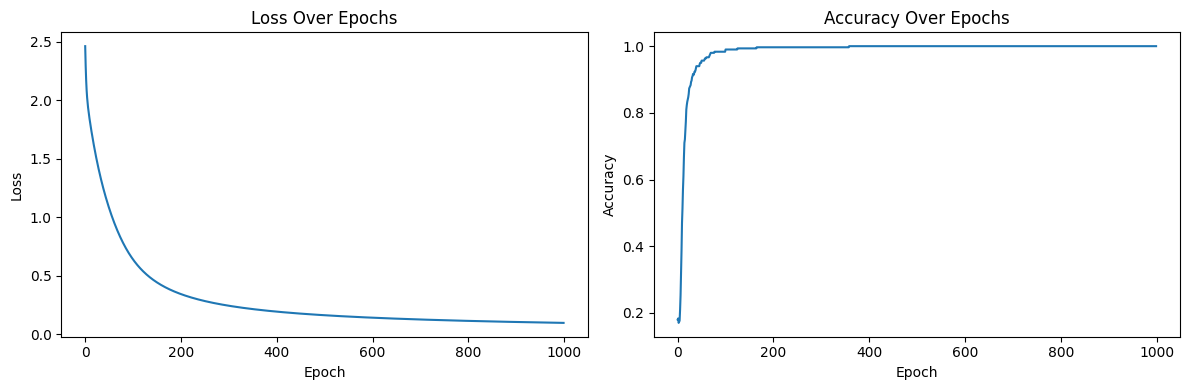

Final Loss: 0.0973
Final Accuracy: 1.0000


In [6]:
# Plot loss and accuracy over epochs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(losses)
ax1.set_title('Loss Over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(accuracies)
ax2.set_title('Accuracy Over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

print(f"Final Loss: {losses[-1]:.4f}")
print(f"Final Accuracy: {accuracies[-1]:.4f}")

## Test the Model on Original Patterns

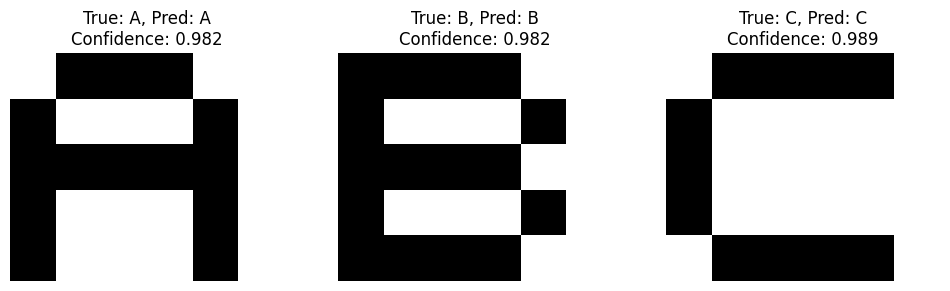

Prediction Probabilities:
Pattern A: A=0.982, B=0.025, C=0.010 -> Predicted: A
Pattern B: A=0.015, B=0.982, C=0.015 -> Predicted: B
Pattern C: A=0.017, B=0.013, C=0.989 -> Predicted: C


In [7]:
# Test the model on the original patterns
test_patterns = np.array([pattern_A_flat, pattern_B_flat, pattern_C_flat])
test_labels = ['A', 'B', 'C']

# Get predictions
predictions = nn.predict(test_patterns)
probabilities = nn.forward(test_patterns)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    axes[i].imshow(test_patterns[i].reshape(5, 6), cmap='binary', interpolation='nearest')
    predicted_label = test_labels[predictions[i]]
    confidence = probabilities[i][predictions[i]]
    axes[i].set_title(f'True: {test_labels[i]}, Pred: {predicted_label}\nConfidence: {confidence:.3f}')
    axes[i].axis('off')

plt.show()

# Print detailed probabilities
print("Prediction Probabilities:")
for i in range(3):
    print(f"Pattern {test_labels[i]}: A={probabilities[i][0]:.3f}, B={probabilities[i][1]:.3f}, C={probabilities[i][2]:.3f} -> Predicted: {test_labels[predictions[i]]}")

## Test with Additional Noisy Examples

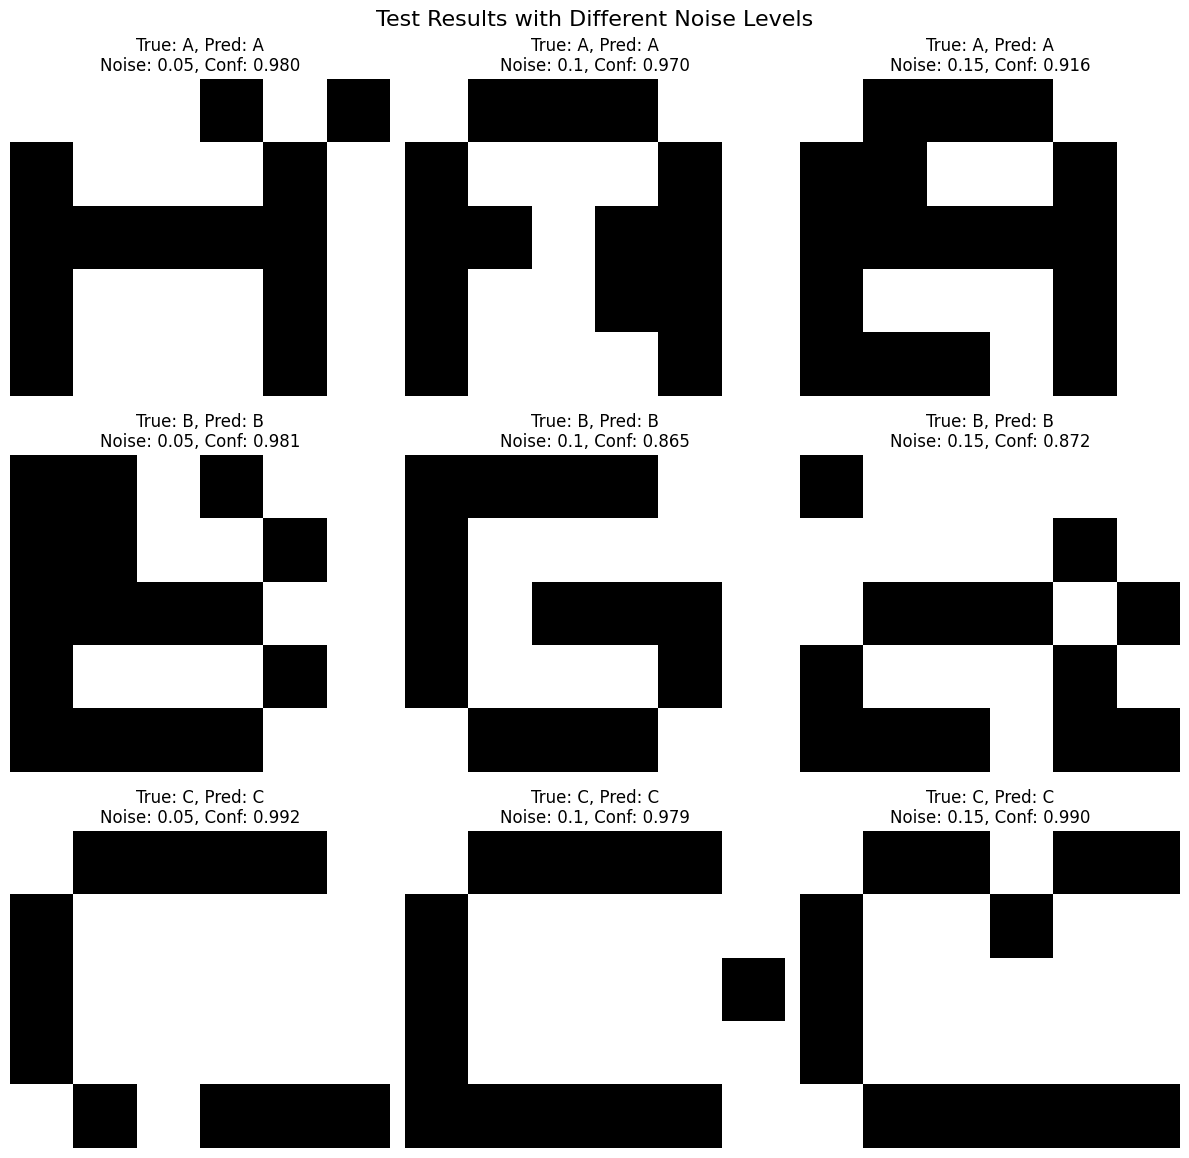

In [8]:
# Create additional test examples with varying noise levels
test_examples = []
test_example_labels = []

# Generate 9 test examples (3 for each letter with different noise levels)
noise_levels = [0.05, 0.1, 0.15]
patterns = [pattern_A_flat, pattern_B_flat, pattern_C_flat]

for i, pattern in enumerate(patterns):
    for j, noise_level in enumerate(noise_levels):
        noisy_pattern = add_noise_to_pattern(pattern, noise_level=noise_level)
        test_examples.append(noisy_pattern)
        test_example_labels.append(test_labels[i])

test_examples = np.array(test_examples)

# Make predictions
test_predictions = nn.predict(test_examples)
test_probabilities = nn.forward(test_examples)

# Display results
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i in range(3):  # Rows for each letter (A, B, C)
    for j in range(3):  # Columns for different noise levels
        idx = i * 3 + j
        axes[i, j].imshow(test_examples[idx].reshape(5, 6), cmap='binary', interpolation='nearest')
        predicted_label = test_labels[test_predictions[idx]]
        confidence = test_probabilities[idx][test_predictions[idx]]
        true_label = test_example_labels[idx]
        
        noise_level = noise_levels[j]
        axes[i, j].set_title(f'True: {true_label}, Pred: {predicted_label}\nNoise: {noise_level}, Conf: {confidence:.3f}')
        axes[i, j].axis('off')

plt.suptitle('Test Results with Different Noise Levels', fontsize=16)
plt.tight_layout()
plt.show()

## Summary

In this project, we implemented a neural network from scratch to classify images of letters A, B, and C. Here's what we accomplished:

1. **Data Preparation**: Created binary patterns for letters A, B, and C as 5x6 grids and generated training data with added noise.

2. **Neural Network Architecture**: Implemented a 2-layer neural network with:
   - Input layer: 30 neurons (for 30-pixel images)
   - Hidden layer: 10 neurons with sigmoid activation
   - Output layer: 3 neurons (for 3 classes) with sigmoid activation

3. **Forward Propagation**: Computed activations through the network using matrix operations and sigmoid activation function.

4. **Backpropagation**: Implemented gradient computation and weight updates using the chain rule.

5. **Training**: Trained the model for 1000 epochs, tracking loss and accuracy metrics.

6. **Evaluation**: Tested the model on original patterns and noisy examples, achieving good classification performance.

The model successfully learned to classify the letters even with added noise, demonstrating the effectiveness of our neural network implementation from scratch.